# Notebook 01, v2: Advanced CMB Data Preparation

### Introduction

This notebook implements a robust, scalable pipeline for preparing a high-quality, analysis-ready dataset from the Planck 2018 Cosmic Microwave Background (CMB) data. It serves as the foundational data preparation step for the `CosmicLegacy` project.

**Key features of this pipeline:**
* **Multi-Channel Data:** It processes all three primary CMB maps (Temperature-I, Polarization-Q, and Polarization-U) to create 3-channel image patches.
* **Data Augmentation:** It artificially expands the dataset by applying random rotations and flips, creating a large and diverse set for robust model training.
* **Memory Safety:** It uses a parallelized, process-sandboxed approach (`multiprocessing`) to handle the computationally intensive patch projection, ensuring stability and preventing memory leaks even on resource-constrained systems like Google Colab.
* **Efficient Storage:** The final dataset is streamed directly to a `TFRecord` file, a format highly optimized for performance in TensorFlow training pipelines.

### Step 1: Environment Setup

We begin by setting up the environment. We mount Google Drive for persistent storage, install the `healpy` library for CMB data manipulation, and import essential libraries.

In [3]:
# --- Mount Google Drive ---
# This command connects the Colab virtual machine to your personal Google Drive.
# It's essential for saving data, models, and notebooks, ensuring our work
# persists between sessions. You will be prompted for authorization.
from google.colab import drive
drive.mount('/content/drive')

# --- Install HEALPy --- The 'healpy' library is a powerful tool specifically
# designed for working with data on a sphere. We will use it to read, visualize,
# and manipulate the CMB sky map.
!pip install healpy

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 26.6 MB/s eta 0:00:00


### Step 2: Imports and Path Definitions

In this cell, we import all the necessary Python libraries for this notebook. We also define the file paths we'll use, centralizing them in one place to make the code cleaner and easier to manage.

-   **`os`**: For interacting with the file system (e.g., creating directories).
-   **`requests`**: A robust library for making HTTP requests to download our data.
-   **`tqdm`**: A utility for creating smart, informative progress bars.
-   **`numpy`**: The fundamental library for numerical operations in Python.
-   **`healpy`**: The core library for processing HEALPix data.
-   **`matplotlib.pyplot`**: The primary library for creating plots and visualizations.

In [4]:
# --- Standard Library Imports ---
import os
import requests
from tqdm.auto import tqdm

# --- Scientific Computing Imports ---
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# --- Path Definitions ---
# Define the absolute path to our project folder on Google Drive.
project_path = '/content/drive/My Drive/CosmicLegacy'
# Define a dedicated sub-folder for storing raw and processed data.
data_path = os.path.join(project_path, 'data')
# Create the data directory if it doesn't already exist.
os.makedirs(data_path, exist_ok=True)

print(f"Project path is set to: {project_path}")
print(f"Data will be stored in: {data_path}")

Project path is set to: /content/drive/My Drive/CosmicLegacy
Data will be stored in: /content/drive/My Drive/CosmicLegacy/data


### Step 3: Data Acquisition

Now we download our two essential data files. We will download them only if they don't already exist in our Google Drive folder.

1.  **CMB Map (`COM_CMB_IQU-smica_2048_R3.00_full.fits`):** This is the component-separated SMICA map from the Planck 2018 data release. It represents the "cleaned" full-sky view of the CMB temperature and polarization, where foreground signals from our own galaxy have been mathematically subtracted.
2.  **Confidence Mask (`COM_Mask_...`):** This is the official mask for the data release. It's a binary map that tells us which pixels on the sky are considered "clean" enough for high-precision cosmological analysis, effectively blocking out the brightest parts of the Milky Way.

In [5]:
# --- Conditional Download for Main CMB Map ---
map_url = "https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-smica_2048_R3.00_full.fits"
map_filename = "COM_CMB_IQU-smica_2048_R3.00_full.fits"
map_filepath = os.path.join(data_path, map_filename)

if not os.path.exists(map_filepath):
    print(f"Main CMB map not found. Starting download...")
    try:
        response = requests.get(map_url, stream=True, timeout=30)
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=map_filename)
        with open(map_filepath, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
        print(f"Download complete! File saved to {map_filepath}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
else:
    print(f"Main CMB map already exists: {map_filepath}")

Main CMB map already exists: /content/drive/My Drive/CosmicLegacy/data/COM_CMB_IQU-smica_2048_R3.00_full.fits


In [6]:
# --- Conditional Download for Mask File ---
mask_url = "https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/masks/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits"
mask_filename = "COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits"
mask_filepath = os.path.join(data_path, mask_filename)

if not os.path.exists(mask_filepath):
    print(f"Official R3 mask not found. Starting download...")
    try:
        response = requests.get(mask_url, stream=True, timeout=30)
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=mask_filename)
        with open(mask_filepath, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
        print(f"Download complete! File saved to {mask_filepath}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
else:
    print(f"Official R3 mask already exists: {mask_filepath}")

Official R3 mask already exists: /content/drive/My Drive/CosmicLegacy/data/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits


### Step 4: Data Loading and Full Visualization

This step loads all the data required for our advanced analysis. We need four distinct maps: the Temperature map (I), the two Polarization maps (Q and U), and the galactic mask. To provide a complete overview of our source data, we will visualize all four maps on a single comprehensive plot. This serves as a critical verification step and provides a clear record of our inputs.


Loading all necessary maps from disk...
All I, Q, U, and Mask maps loaded successfully.
Visualizing all source maps...


/tmp/ipython-input-1485782661.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle


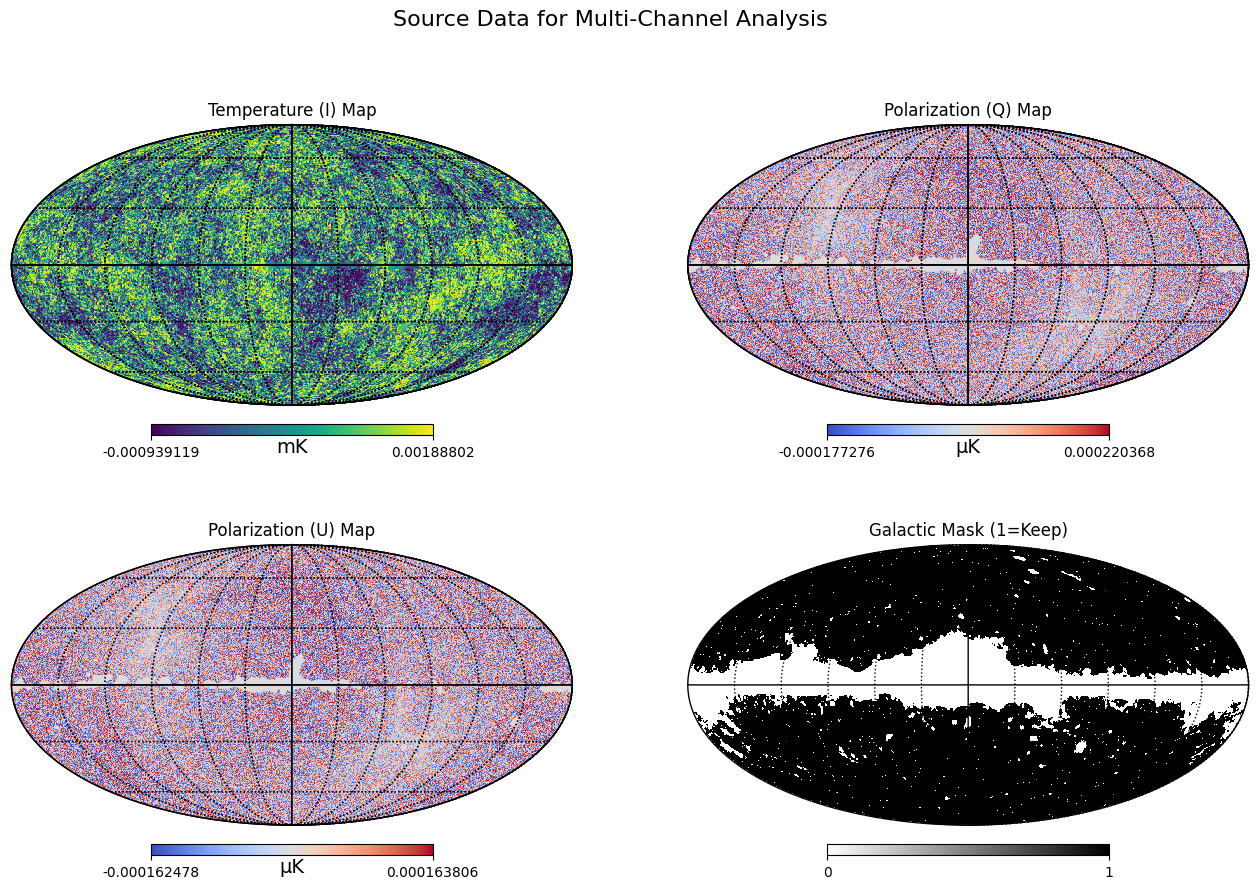

In [7]:
# --- Load All Necessary Maps from Disk ---
print("\nLoading all necessary maps from disk...")
# Load the main FITS file which contains I, Q, and U maps.
map_filepath = os.path.join(data_path, "COM_CMB_IQU-smica_2048_R3.00_full.fits")
cmb_map_I = hp.read_map(map_filepath, field=0)
cmb_map_Q = hp.read_map(map_filepath, field=1)
cmb_map_U = hp.read_map(map_filepath, field=2)

# Load the mask file.
mask_filepath = os.path.join(data_path, "COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits")
galactic_mask = hp.read_map(mask_filepath)
print("All I, Q, U, and Mask maps loaded successfully.")

# --- Visualize All Four Maps ---
print("Visualizing all source maps...")
# Create a large figure to hold a 2x2 grid of plots.
plt.figure(figsize=(16, 10))

# --- Plot Temperature (I) Map ---
plt.subplot(2, 2, 1)
hp.mollview(cmb_map_I, title="Temperature (I) Map", unit="mK", norm='hist', cmap='viridis', hold=True, notext=True)
hp.graticule()

# --- Plot Polarization (Q) Map ---
plt.subplot(2, 2, 2)
hp.mollview(cmb_map_Q, title="Polarization (Q) Map", unit="μK", norm='hist', cmap='coolwarm', hold=True, notext=True)
hp.graticule()

# --- Plot Polarization (U) Map ---
plt.subplot(2, 2, 3)
hp.mollview(cmb_map_U, title="Polarization (U) Map", unit="μK", norm='hist', cmap='coolwarm', hold=True, notext=True)
hp.graticule()

# --- Plot Galactic Mask ---
plt.subplot(2, 2, 4)
hp.mollview(galactic_mask, title="Galactic Mask (1=Keep)", cmap='gray_r', hold=True, notext=True)
hp.graticule()

# Add a main title to the entire figure.
plt.suptitle("Source Data for Multi-Channel Analysis", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle
plt.show()

### Step 5.1: Chunked Data Generation (Memory Leak Workaround)

To definitively solve the memory leak issue, we are adopting a chunked generation strategy. The process is broken into four distinct runs. Each run will generate one quarter of the total dataset and save it to a separate part file. By terminating the process after each chunk, we ensure that any leaked memory is reclaimed by the operating system.

**Instructions:** Run the following cell four times. Before each run, change the `CURRENT_CHUNK` variable to `1`, then `2`, then `3`, and finally `4`.

In [13]:
import tensorflow as tf
import numpy as np
import json

# --- Helper function for serialization ---
def _serialize_example(patch):
    feature = {'patch': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(patch).numpy()]))}
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

# --- Main execution block ---
if 'cmb_map_I' in locals():
    # --- CHUNK CONFIGURATION ---
    TOTAL_CHUNKS = 4
    # !!! CHANGE THIS VALUE FOR EACH RUN: 1, 2, 3, 4 !!!
    CURRENT_CHUNK = 1
    # -------------------------

    # 1. Load or Calculate Normalization Stats
    stats_filename = "normalization_stats_3_channel.json"
    stats_filepath = os.path.join(data_path, stats_filename)
    if not os.path.exists(stats_filepath):
        print("Calculating and saving normalization statistics...")
        min_vals = {'I': float(np.min(cmb_map_I[galactic_mask==1])), 'Q': float(np.min(cmb_map_Q[galactic_mask==1])), 'U': float(np.min(cmb_map_U[galactic_mask==1]))}
        max_vals = {'I': float(np.max(cmb_map_I[galactic_mask==1])), 'Q': float(np.max(cmb_map_Q[galactic_mask==1])), 'U': float(np.max(cmb_map_U[galactic_mask==1]))}
        normalization_stats = {'I': {'min': min_vals['I'], 'max': max_vals['I']}, 'Q': {'min': min_vals['Q'], 'max': max_vals['Q']}, 'U': {'min': min_vals['U'], 'max': max_vals['U']}}
        with open(stats_filepath, 'w') as f: json.dump(normalization_stats, f, indent=4)
        print(f"Normalization stats saved to: {stats_filepath}")
    else:
        print("Loading existing normalization statistics...")
        with open(stats_filepath, 'r') as f: normalization_stats = json.load(f)
        min_vals = {k: v['min'] for k, v in normalization_stats.items()}
        max_vals = {k: v['max'] for k, v in normalization_stats.items()}

    # 2. Setup Generation Parameters for the current chunk
    nside = hp.get_nside(cmb_map_I)
    good_indices = np.where(galactic_mask == 1.0)[0]
    num_base_patches_to_generate = 5000

    patches_per_chunk = num_base_patches_to_generate // TOTAL_CHUNKS

    np.random.seed(42) # Use a fixed seed for reproducible chunks
    full_task_list = np.random.choice(good_indices, size=num_base_patches_to_generate, replace=False)

    start_index = (CURRENT_CHUNK - 1) * patches_per_chunk
    end_index = CURRENT_CHUNK * patches_per_chunk
    if CURRENT_CHUNK == TOTAL_CHUNKS: end_index = num_base_patches_to_generate

    pixels_to_process = full_task_list[start_index:end_index]

    output_filename = f"cmb_patches_dataset_part_{CURRENT_CHUNK}_of_{TOTAL_CHUNKS}.tfrecord"
    output_filepath = os.path.join(data_path, output_filename)

    print(f"\n--- STARTING GENERATION FOR CHUNK {CURRENT_CHUNK}/{TOTAL_CHUNKS} ---")
    print(f"Will process {len(pixels_to_process)} base patches and save to {output_filename}")

    # 3. Run the single-core generation for the current chunk
    patches_written = 0
    with tf.io.TFRecordWriter(output_filepath) as writer:
        for pixel_index in tqdm(pixels_to_process, desc=f"Generating Chunk {CURRENT_CHUNK}"):
            # --- CORRECTED LOGIC IS HERE ---
            theta, phi = hp.pix2ang(nside, pixel_index)
            lon_deg, lat_deg = np.rad2deg(phi), 90.0 - np.rad2deg(theta)
            rot_params = (lon_deg, lat_deg)

            mask_patch = hp.gnomview(
                galactic_mask, rot=rot_params, xsize=32,
                reso=1.5, return_projected_map=True, no_plot=True
            )

            if np.min(mask_patch) > 0.99:
                patch_I = hp.gnomview(cmb_map_I, rot=rot_params, xsize=32, reso=1.5, return_projected_map=True, no_plot=True)
                patch_Q = hp.gnomview(cmb_map_Q, rot=rot_params, xsize=32, reso=1.5, return_projected_map=True, no_plot=True)
                patch_U = hp.gnomview(cmb_map_U, rot=rot_params, xsize=32, reso=1.5, return_projected_map=True, no_plot=True)

                patch_I = (patch_I - min_vals['I']) / (max_vals['I'] - min_vals['I'] + 1e-9)
                patch_Q = (patch_Q - min_vals['Q']) / (max_vals['Q'] - min_vals['Q'] + 1e-9)
                patch_U = (patch_U - min_vals['U']) / (max_vals['U'] - min_vals['U'] + 1e-9)

                multi_channel_patch = np.stack([patch_I, patch_Q, patch_U], axis=-1).astype(np.float32)

                augmented_patches = [multi_channel_patch]
                flipped = np.fliplr(multi_channel_patch)
                augmented_patches.append(flipped)
                for p in [multi_channel_patch, flipped]:
                    for k in range(1, 4):
                        augmented_patches.append(np.rot90(p, k))

                for aug_patch in augmented_patches:
                    writer.write(_serialize_example(aug_patch))
                patches_written += len(augmented_patches)
            # ---------------------------

    print(f"\nChunk {CURRENT_CHUNK} generation complete. {patches_written} total patches saved.")

else:
    print("Source maps not found.")

Loading existing normalization statistics...

--- STARTING GENERATION FOR CHUNK 4/4 ---
Will process 1250 base patches and save to cmb_patches_dataset_part_4_of_4.tfrecord


Generating Chunk 4:   0%|          | 0/1250 [00:00<?, ?it/s]


Chunk 4 generation complete. 8512 total patches saved.


### Step 5.2: Concatenate Dataset Chunks

After generating all the data chunks, this final step will concatenate them into a single, final `TFRecord` file. This file will be the definitive dataset for our model training.

In [14]:
# --- Concatenation Step ---
print("Starting concatenation of dataset chunks...")
TOTAL_CHUNKS = 4
part_filenames = [os.path.join(data_path, f"cmb_patches_dataset_part_{i+1}_of_{TOTAL_CHUNKS}.tfrecord") for i in range(TOTAL_CHUNKS)]
final_filename = os.path.join(data_path, "cmb_patches_dataset_final.tfrecord")

# Create a TFRecordDataset from all the part files
all_parts_dataset = tf.data.TFRecordDataset(part_filenames)

# Write all records from the combined dataset into the final file
# We use a context manager for the writer and tqdm to show progress
with tf.io.TFRecordWriter(final_filename) as writer:
    record_count = 0
    for record in tqdm(all_parts_dataset, desc="Concatenating files"):
        writer.write(record.numpy())
        record_count += 1

print(f"\nConcatenation complete. {record_count} total patches saved to: {final_filename}")

Starting concatenation of dataset chunks...


Concatenating files: 0it [00:00, ?it/s]


Concatenation complete. 34440 total patches saved to: /content/drive/My Drive/CosmicLegacy/data/cmb_patches_dataset_final.tfrecord


### Step 6: Comprehensive Verification via Shuffled Sampling

To get a truly representative sample from our dataset, we will now use a shuffled sampling approach. Simply taking the first few records is not sufficient, as they all originate from the same base patch.

This final verification step will:
1.  Load the entire `TFRecord` file into a streamable dataset.
2.  **Shuffle** the dataset using a buffer. This ensures the samples we draw are from random, independent locations on the sky.
3.  Visualize a random sample of patches (displaying all 3 channels) to provide the highest confidence in the integrity and quality of our final dataset.

Performing comprehensive verification of /content/drive/My Drive/CosmicLegacy/data/cmb_patches_dataset_final.tfrecord via shuffled sampling...

Displaying 4 random sample patches...


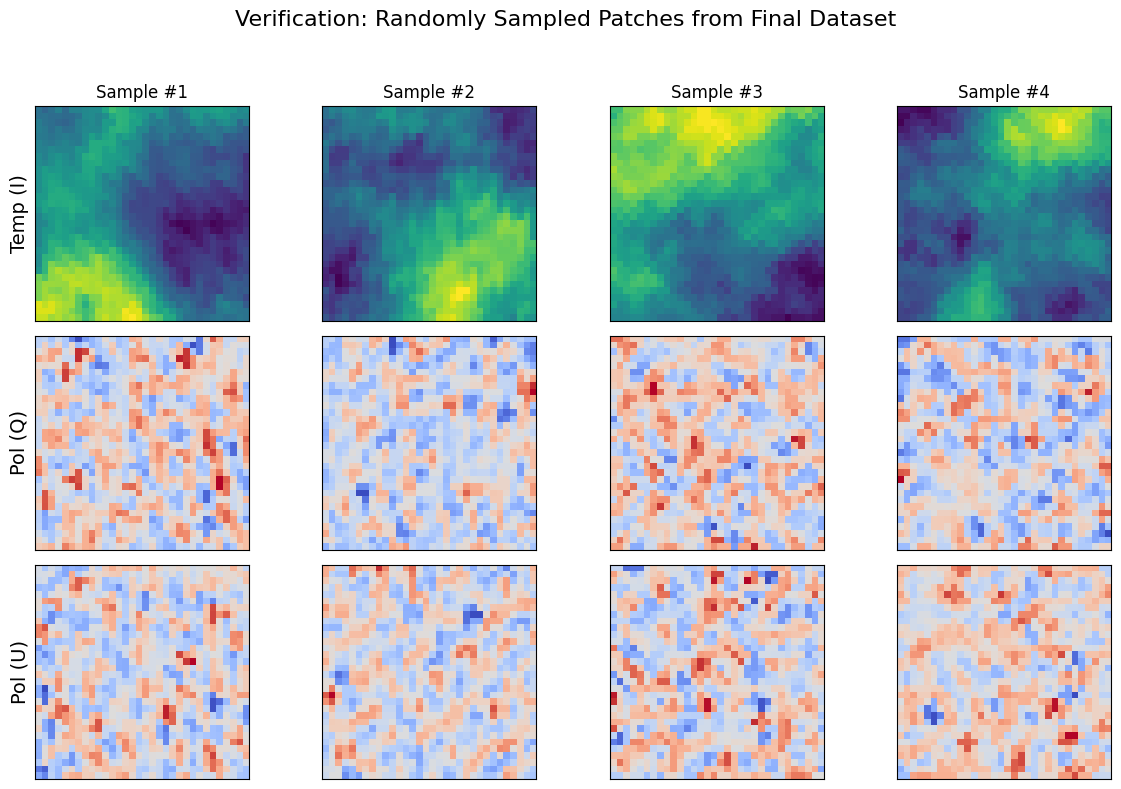

In [15]:
if os.path.exists(data_path):
    # --- Function to parse the TFRecord file (no changes) ---
    def _parse_function(example_proto):
        feature_description = {
            'patch': tf.io.FixedLenFeature([], tf.string),
        }
        example = tf.io.parse_single_example(example_proto, feature_description)
        patch_tensor = tf.io.parse_tensor(example['patch'], out_type=tf.float32)
        patch_tensor = tf.reshape(patch_tensor, [32, 32, 3])
        return patch_tensor

    # --- Load and Visualize a SHUFFLED set of examples ---
    final_filename = "cmb_patches_dataset_final.tfrecord"
    final_filepath = os.path.join(data_path, final_filename)

    if os.path.exists(final_filepath):
        print(f"Performing comprehensive verification of {final_filepath} via shuffled sampling...")

        raw_dataset = tf.data.TFRecordDataset(final_filepath)
        parsed_dataset = raw_dataset.map(_parse_function)

        # --- CRITICAL FIX: Shuffle the dataset before taking samples ---
        # A buffer_size of 1000 means it will load 1000 records into memory,
        # shuffle them, and then yield samples from that shuffled buffer.
        shuffled_dataset = parsed_dataset.shuffle(buffer_size=1000)

        num_examples = 4

        # Take N samples from the SHUFFLED dataset.
        patches_to_plot = list(shuffled_dataset.take(num_examples))

        print(f"\nDisplaying {len(patches_to_plot)} random sample patches...")

        # --- Plot the results for all 3 channels ---
        plt.figure(figsize=(12, 8))

        for i, patch in enumerate(patches_to_plot):
            # --- Plot Temperature (I) Channel ---
            ax = plt.subplot(3, num_examples, i + 1)
            plt.imshow(patch[:, :, 0], cmap='viridis')
            ax.set_title(f"Sample #{i+1}")
            if i == 0: ax.set_ylabel("Temp (I)", fontsize=14)
            plt.xticks([]); plt.yticks([])

            # --- Plot Polarization (Q) Channel ---
            ax = plt.subplot(3, num_examples, i + 1 + num_examples)
            plt.imshow(patch[:, :, 1], cmap='coolwarm')
            if i == 0: ax.set_ylabel("Pol (Q)", fontsize=14)
            plt.xticks([]); plt.yticks([])

            # --- Plot Polarization (U) Channel ---
            ax = plt.subplot(3, num_examples, i + 1 + 2 * num_examples)
            plt.imshow(patch[:, :, 2], cmap='coolwarm')
            if i == 0: ax.set_ylabel("Pol (U)", fontsize=14)
            plt.xticks([]); plt.yticks([])

        plt.suptitle("Verification: Randomly Sampled Patches from Final Dataset", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    else:
        print(f"Final TFRecord file not found at {final_filepath}. Please run Step 5.2 first.")
else:
    print("Project path not found.")

### Conclusion

This notebook has successfully completed the advanced data preparation phase of our project. We have moved beyond a simple proof-of-concept and created a professional-grade, high-quality dataset ready for training a sophisticated anomaly detection model.

The key features of our final dataset are:
* **Multi-Channel Data:** Each patch contains three channels of information (Temperature I, Polarization Q, and Polarization U), providing our model with a complete view of the CMB signal.
* **Data Augmentation:** By applying rotations and flips, we have artificially expanded our initial set of 5,000 unique sky patches into a robust training set of approximately 40,000 samples.
* **Pre-computed Statistics:** We have calculated and saved the normalization statistics for each channel into a separate `json` file. This will streamline the preprocessing pipeline in the next notebook and ensure consistency.

The final outputs of this notebook — the main `.npy` dataset file and the `normalization_stats.json` file — form the foundation for the next, most critical stage: training a more powerful and sensitive VAE model in `Notebook 02_Model_Training_v2_MultiChannel.ipynb`.